In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch
from torch import nn
import torch.nn.functional as f
from torchvision import datasets, transforms
from torch.utils.data import Dataset

from utils import flat_to_triangular, make_cholesky, plot, clean_curr_axes, onehot, log_sum_exp

np.random.seed(3)

### $N$-dimensional features, scalar regression target, with covariance

### Problem

We consider a classification problem with $K$ classes, inputs $\mathbf{x}$, and target classes $\mathbf{t}$, where each target $t_i$ is a scalar denoting the class of $x_i$. We wish to learn a bayesian linear model with learnt basis functions, and take the output of such model as score for the different classes.

### Known basis function

In the case of a known deterministic $D$-dimensional basis function $\phi$, the predicted probability for the different classes for example $x_i$ is:

\begin{align}
    \mathbf{y} = \mathrm{softmax} (\mathbf{a} \phi(x_i) + \mathbf{b})
\end{align}

where $\mathbf{y}$ and $\mathbf{b}$ are $K$-vectors, $\mathbf{a}$ is a $K \times D$ matrix, and the softmax is computed over the $K$ classes.
The likelihood of a data point $(x_i, t_i)$ is:

\begin{align}
p(t_i \ |\ \mathbf{a}, \mathbf{b}, x_i) & = y[t_i]
\end{align}

i.e. the model output for the true class $t_i$. Assuming independence, the likelihood of the parameters given the entire dataset is simply the product of the above.

We define the prior over the parameters as an isotropic Gaussian, which gives:

\begin{align}
 p(\mathbf{a}) = \mathcal{N}(0,\mathbf{I}) \qquad  p(\mathbf{b}) = \mathcal{N}(0,\mathbf{I})
\end{align}

The posterior of the parameters, with $(\mathbf{x}, \mathbf{t})$ the entire dataset, is:

\begin{align}
p(\mathbf{a}, \mathbf{b} \ |\ \mathbf{t} , \mathbf{x}) = \frac{p(\mathbf{t}\ |\ \mathbf{a}, \mathbf{b}, \mathbf{x}) p(\mathbf{a}, \mathbf{b})}{p(\mathbf{t} \ |\ \mathbf{x})}
\end{align}

The denominator $p(\mathbf{t} | \mathbf{x})$ is tractable and constant, hence we can also approximate the posterior using our favorite MCMC methods.


### Learnt basis function

#### Bayes by Backprop

Let $\mathbf{w}$ be the vector with all the parameters $\mathbf{a}$ and $\mathbf{b}$, having size $D' = (D+1)K$. As basis function we use $f_\theta$, a neural network parameterized by a vector $\theta$. This effectively corresponds to a neural network where the last layer is Bayesian.

We approximate the posterior parameter distribution $p(\mathbf{w} \ |\ \mathcal{D})$ with

$$q(\mathbf{w}) = \mathcal{N}(\boldsymbol{\mu}_{\mathbf{w}}, \boldsymbol{\Sigma}_{\mathbf{w}})$$

and optimize this distribution with variational inference, whereas $\theta$ is estimated by maximum likelihood. We do this by deriving a lower bound of the marginal log likelihood that we can optimize end-to-end with respect to $\theta$, $\boldsymbol{\mu}_{\mathbf{w}}$, and $ \boldsymbol{\Sigma}_{\mathbf{w}}$. We have:

\begin{align}
\log p(\mathbf{t} | \mathbf{x};\theta) & = \log \int_{\mathbf{w}} p(\mathbf{t}, \mathbf{w} \ |\  \mathbf{x};  \theta) d\mathbf{w} \\
& = \log \int_{\mathbf{w}} p(\mathbf{t} \ |\  \mathbf{w}, \mathbf{x};  \theta)p(\mathbf{w}) d\mathbf{w} \\
& = \log \int_{\mathbf{w}} q(\mathbf{w}) p(\mathbf{t} \ |\  \mathbf{w}, \mathbf{x};  \theta) \frac{p(\mathbf{w})}{q(\mathbf{w})} d\mathbf{w} \\
& \geq \mathbb{E}_{q(\mathbf{w})} \left[ \log  p(\mathbf{t} \ |\ \mathbf{w}, \mathbf{x}; \theta) \frac{p(\mathbf{w})}{q(\mathbf{w})} \right] \\
& = \mathbb{E}_q[\log p(\mathbf{t}\ |\ \mathbf{w}, \mathbf{x}; \theta)] - \mathrm{KL}(q(\mathbf{w}) \ ||\ p(\mathbf{w})) \\
&= \mathcal{L (q,\theta)}
\end{align}

#### Modelling the posterior of vector quantities with covariance

We choose to model the approximate posterior of $\mathbf{w}$ using a **Multivariate Gaussian** where the covariance matrix $\boldsymbol{\Sigma}$ is parametrized by using the Cholesky decomposition $\boldsymbol{\Sigma}=\mathbf{L}\mathbf{L}^T$, which allows us to apply the reparametrization trick:

\begin{align}
\mathbf{w} = \boldsymbol{\mu} + \mathbf{L} \boldsymbol{\epsilon}, \quad 
\boldsymbol{\epsilon} \sim \mathcal{N}(0, \mathbf{I}) \quad \Rightarrow \quad
\mathbf{w} \sim \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma})
\end{align}

where we can easily see that the mean of $\mathbf{w}$ is $\boldsymbol{\mu}$, and the covariance is indeed $\boldsymbol{\Sigma}$:

\begin{aligned}
\mathrm{cov} (\mathbf{w}) &=\mathbb{E}\left[(\mathbf{w}-\mathbb{E}[\mathbf{w} ])(\mathbf{w}-\mathbb{E}[\mathbf{w} ])^{T}\right] \\ 
&=\mathbb{E}\left[\mathbf{L} \boldsymbol{\epsilon}(\mathbf{L} \boldsymbol{\epsilon})^{T}\right] \\ 
&=\mathbb{E}\left[\mathbf{L} \boldsymbol{\epsilon} \boldsymbol{\epsilon}^{T} \mathbf{L}^{T}\right] \\ 
&=\mathbf{L} \mathbb{E}\left[\boldsymbol{\epsilon} \boldsymbol{\epsilon}^{T}\right] \mathbf{L}^{T} \\ 
&=\mathbf{L} \mathbf{L}^{T} = \boldsymbol{\Sigma}
\end{aligned}


The two terms we need to compute the ELBO are as follows:

\begin{split}
\mathbb{E}_q[\log p(\mathbf{t}\ |\ \mathbf{w}, \mathbf{x} ; \theta)] &=  \mathbb{E}_q \left[ \sum_{i = 1}^N \log p(t_i \ |\ \mathbf{w}, x_i) \right] = \mathbb{E}_q \left[ \sum_{i = 1}^N \log y[t_i] \right] \\
\mathrm{KL}(q(\mathbf{w}) \ ||\ p(\mathbf{w})) &= -\frac{1}{2} \sum_{i=1}^{D'} \left(1 + \log L_{i,i}^2 - \mu_i^2 - \Sigma_{i,i}\right)
\end{split}

where $N$ is the data set size, and the expectation is estimated by MC. Here we used the KL divergence between multivariate Gaussian distributions:

\begin{aligned}
\mathrm{KL}(q\ ||\ p)
    &= \frac{1}{2} \left( \log |\boldsymbol{\Sigma}_ p| - \log |\boldsymbol{\Sigma}_ q| - D' + \mathrm{tr} (\boldsymbol{\Sigma}_p^{-1} \boldsymbol{\Sigma}_q) + (\boldsymbol{\mu}_p - \boldsymbol{\mu}_q)^T  \boldsymbol{\Sigma}_p (\boldsymbol{\mu}_p - \boldsymbol{\mu}_q)\right) \\
    & = \frac{1}{2} \left( - \log \left(|\boldsymbol{L}|^2\right) - D' + \mathrm{tr} (\boldsymbol{\Sigma}_q) +  \boldsymbol{\mu}_q^T \boldsymbol{\mu}_q\right) \\
    & = -\frac{1}{2} \left(D' + \sum_{i=1}^{D'} \log L_{ii}^2 - \sum_{i=1}^{D'} (\boldsymbol{\Sigma}_q)_{ii} - \sum_{i=1}^{D'} (\boldsymbol{\mu}_q)_i^2 \right)
\end{aligned}

### Papers

[Gaussian variational approximation with a factor covariance structure](https://arxiv.org/pdf/1701.03208.pdf)

[Pathwise Derivatives Beyond the Reparameterization Trick](https://arxiv.org/pdf/1806.01851.pdf)

[Kingma's Talk](https://berkeley-deep-learning.github.io/cs294-131-s17/slides/VAE%20talk.compressed.pdf)


#### small MNIST

We using the MNIST dataset and sample 600 training examples.

In [2]:
n_max_train = 600
batch_size = 256
test_batch_size = 256


transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])

class SubMNIST(datasets.MNIST):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        idx = list(range(super().__len__()))
        self.idx = np.random.choice(idx, size=n_max_train, replace=False)
            
    def __len__(self):
        return len(self.idx)
    
    def __getitem__(self, index):
        idx = self.idx[index]
        return super().__getitem__(idx)
            
    
if n_max_train is not None:
    train_cls = SubMNIST
else:
    train_cls = datasets.MNIST
    
train_dataset = train_cls('data', train=True, download=True,transform=transform)
test_dataset = datasets.MNIST('data', train=False, download=True,transform=transform)

kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
train_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=test_batch_size, shuffle=True, **kwargs)

n_classes = 10
print(f"Number of training examples: {len(train_loader.dataset)}")
print(f"Number of testing examples: {len(test_loader.dataset)}")

Number of training examples: 600
Number of testing examples: 10000


#### Features extractor and stochastic layer

Define function $f_{\theta}$ to extract features $\mathbf{h} = f_{\theta}(x)$, with parameters $\theta$ to be optimized. The features $\mathbf{h}$ have size $m$, the weight matrix $\mathbf{a}$ has shape $m \times k$, the bias $\mathbf{b}$ has size $k$, and $k$ is the number of classes. Logits are $\mathbf{h \cdot a} + \mathbf{b}$, with $\mathbf{a}$ and $\mathbf{b}$ multivariate Normal rvs with full covariance (including correlation between $\mathbf{a}$ and $\mathbf{b}$).

The stochastic layer has no state, it's only used to get samples from $\mathcal{N}(\mu, \Sigma)$, and to compute the KL divergence from a prior $\mathcal{N}(0, I)$ to a variational distribution $q = \mathcal{N}(\mu, \Sigma)$.

In [126]:
class FeaturesExtractor(nn.Module):
    def __init__(self, n_out):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(1, 16, 5, stride=2), nn.LeakyReLU(),
            nn.Conv2d(16, 32, 5, stride=2), nn.LeakyReLU(),
        )
        self.fcs = nn.Sequential(
            nn.Linear(4*4*32, 128), nn.LeakyReLU(),
            nn.Linear(128, n_out), nn.LeakyReLU(),
        )
        
    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        return self.fcs(x)
    
    
class CovarianceStochasticLayer(nn.Module):
    def __init__(self, deterministic=False):
        super().__init__()
        self.deterministic = deterministic

    def forward(self, mu_q, cholesky):
        if self.deterministic:
            return mu_q
        else:
            eps = torch.randn_like(mu_q)
            return mu_q + eps @ cholesky
    
    def forward_diagonal(self, mu_q, logvar_q):
        eps = torch.randn_like(mu_q)
        std = (logvar_q/2).exp()
        return mu_q + std * eps

    def get_kl(self, mu_q, L_logdiag_q, L_q):
        if not self.deterministic:
            kl = -0.5 * (1 + L_logdiag_q - mu_q.pow(2) - torch.diag(L_q @ L_q.permute(1, 0)))
            #print(L_logdiag_q.sum().item(), mu_q.pow(2).sum().item(), torch.diag(L_q @ L_q.permute(1, 0)).sum().item())
            return kl.sum()
        else:
            return 0.

class BayesianClassifier(nn.Module):
    def __init__(self, n_classes, last_layer_size, deterministic=False):
        super().__init__()
        self.features = FeaturesExtractor(n_out=last_layer_size)
        self.stochastic = CovarianceStochasticLayer(deterministic)
        
        self.n_classes = n_classes
        self.last_layer_size = last_layer_size
        self.a_shape = (last_layer_size, n_classes)  # shape of stochastic weight matrix
        self.a_size = np.prod(self.a_shape)
        self.b_size = n_classes
        n_parameters = self.a_size + self.b_size
        
        self.mu_ab = nn.Parameter(torch.zeros((n_parameters)))
        self.logvar_ab = nn.Parameter(-3 * torch.ones((n_parameters)))
        self.cov_ab_params = nn.Parameter(torch.zeros((n_parameters*(n_parameters-1)//2)).normal_() * 0.01)
        
    def forward(self, x, t, n_samples=1):
        mu_ab = self.mu_ab
        logvar_ab = self.logvar_ab
        cov_ab_params = self.cov_ab_params
        batch_size = x.size(0)
        h = self.features(x)
        cov_ab = flat_to_triangular(cov_ab_params)

        # sample n_samples times a and b
        mu = self.mu_ab.unsqueeze(0).expand(n_samples, -1)
        L = make_cholesky(logvar_ab, cov_ab)
        ab_sample = self.stochastic(mu, L) 
        a, b = ab_sample[:, :-self.b_size], ab_sample[:, -self.b_size:]

        # reshape into [n_samples, *]
        a = a.unsqueeze(1).view(-1, *self.a_shape)
        b = b.unsqueeze(1)

        # compute y of size [n_samples x batch_size x n_classes]
        y = h @ a + b   # stochasticity here only comes from a and b

        # extend t and flatten 
        t = t.unsqueeze(0).expand(n_samples, batch_size)
        t = t.contiguous().view(-1)
        y = y.contiguous().view(-1, self.n_classes)

        # Reconstruction loss, estimated by MC
        recons = f.cross_entropy(y, t, reduction='none')
        recons = recons.view(n_samples, batch_size)

        # Accuracy
        y = y.view(n_samples, batch_size, self.n_classes)
        t = t.view(n_samples, batch_size)
        pred_class = torch.max(y.detach(), dim=2)[1]   # tensor of indices
        acc = torch.mean((t==pred_class).float(), 0)

        # KL loss, both analytic and by MC
        kl = self.stochastic.get_kl(mu_ab, logvar_ab, L)

        # compute elbo and view as [n_samples x batch_size]
        elbo = - recons - kl 
        elbo = elbo.view(n_samples, batch_size)
        
        return {'elbo':elbo, 'accuracy':acc, 'y':y, 'nll': recons, 'kl':kl}
        

### Optimize

#### Objective

Here we maximize the ELBO $\mathcal{L}$ with respect to the variational parameters $\boldsymbol{\mu}_{\mathbf{w}}$ and $\boldsymbol{\Sigma}_{\mathbf{w}}$, and the NN parameters $\theta$.

First we train the model with ML (no sampling, just train means), then compare with the Bayesian one.

#### Mini-batch

We compute the ELBO per mini-batch and not on the entire dataset. Consequently, we need to reweight the $KL$ such as:

\begin{align}
ELBO_{mini batch} = \sum_{i=1}^n \log p(t | w, x) - \frac{1}{N_{batches}} KL( q(w) || p(w) )
\end{align}

#### Marginal predictive log-likelihood

We also estimate the marginal predictive log-likelihood as:

\begin{aligned}
\log p(\mathbf{t} | \mathbf{x}, \mathcal{D}; \theta) & = \log \int_{\mathbf{w}} p(\mathbf{t} \ |\ \mathbf{w}, \mathbf{x};  \theta) p(\mathbf{w}\ |\ \mathcal{D}) d\mathbf{w}\\
& \approx \log \int_{\mathbf{w}} p(\mathbf{t} \ |\ \mathbf{w}, \mathbf{x};  \theta) q(\mathbf{w}\ |\ \mathcal{D}) d\mathbf{w}\\
&= \log \mathbb{E}_{q(\mathbf{w}\ |\ \mathcal{D})} \left[p(\mathbf{t} \ |\ \mathbf{w}, \mathbf{x};  \theta)\right]  \\
& \approx \log \left( \frac{1}{S} \sum_{s=1}^S p(\mathbf{t} \ |\ \mathbf{w}_s, \mathbf{x};  \theta) \right) \\
&= \log \left(\sum_{s=1}^S p(\mathbf{t} \ |\ \mathbf{w}_s, \mathbf{x};  \theta) \right) - \log S
\end{aligned}

where the inputs and targets of the test set are denoted as $\mathbf{x}$ and $\mathbf{t}$ respectively, $\mathcal{D}$ is the whole training set, and the weights are sampled from the approximate posterior:

$$\mathbf{w}_s \sim q(\mathbf{w} \ |\ \mathcal{D})$$

In [152]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
deterministic = True
last_layer_size = 64
n_classes = 10
model = BayesianClassifier(n_classes, last_layer_size, deterministic=deterministic)
model.to(device)

N_train = len(train_loader.dataset)
N_test = len(test_loader.dataset)
N_train_batch = N_train // batch_size

l_rate = 1e-3
epochs = 500
n_samples = 10  # MC samples per example

optimiser = torch.optim.Adam(list(model.parameters()), lr = l_rate)
    
test_accs, test_logp, test_steps = [], [], []
step = 0
for epoch in range(1, epochs + 1):
    for batch_idx, (x, t) in enumerate(train_loader):
        model.train()
        x, t = x.to(device), t.to(device)
        optimiser.zero_grad()
        
        data = model(x, t, n_samples=n_samples if not deterministic else 1)
        elbo = data.get('elbo')
        recons = data.get('nll')
        kl = data.get('kl')
        acc = data.get('accuracy')

        # IW averaging
        elbo = - recons.mean(0).sum() - kl / float(N_train_batch)
        # elbo = log_sum_exp(elbo, dim=0, sum_op=torch.mean)

        loss = - elbo
        loss.backward()
        optimiser.step()
        step += 1
        if step % 50 == 0:
            print(f'Epoch {epoch}  step {step} : loss {loss.item():.3f} ELBO {elbo.item():.3f}  NLL '
                  f'{recons.mean().item():.3f}  KL {kl/N_train:.3f}   acc {acc.mean().item():.3f}  Avg. Elbo {elbo/N_train:.3f}')
            
        if step % 100 == 0:
            model.eval()
            with torch.no_grad():
                reconss = []
                accs = []
                for x, t in test_loader:
                    x, t = x.to(device), t.to(device)
                    data = model(x, t)
                    elbo = data.get('elbo')
                    recons = data.get('nll')
                    kl = data.get('kl')
                    acc = data.get('accuracy')
                    reconss += [recons]
                    accs += [acc]
                reconss = torch.cat(reconss, 1)
                acc = torch.cat(accs, 0).mean().item()
                logp = - log_sum_exp(reconss, dim=0, sum_op=torch.mean).sum().item()
                print(f"TEST epoch {epoch} step {step} : logp {logp:.3f} Accuracy: {acc:.3f} Avg. logp {logp/N_test:.3f}")
                test_accs += [acc]
                test_logp += [logp]
                test_steps += [step]

                with open(f"mnist-covariance{('-deterministic' if deterministic else '')}.txt", 'w') as fi:
                    for i,acc,logp in zip(test_steps, test_accs, test_logp):
                        fi.write(f"{i},{acc},{logp}\n")
                          
                path = f"mnist-covariance{('-deterministic' if deterministic else '')}.pt"
                torch.save(model, path)

Epoch 17  step 50 : loss 121.322 ELBO -121.322  NLL 0.474  KL 0.000   acc 0.812  Avg. Elbo -0.202
Epoch 34  step 100 : loss 47.272 ELBO -47.272  NLL 0.185  KL 0.000   acc 0.930  Avg. Elbo -0.079
TEST epoch 34 step 100 : logp -5027.987 Accuracy: 0.864 Avg. logp -0.503
Epoch 50  step 150 : loss 4.645 ELBO -4.645  NLL 0.053  KL 0.000   acc 1.000  Avg. Elbo -0.008
Epoch 67  step 200 : loss 3.699 ELBO -3.699  NLL 0.014  KL 0.000   acc 1.000  Avg. Elbo -0.006
TEST epoch 67 step 200 : logp -6589.731 Accuracy: 0.883 Avg. logp -0.659
Epoch 84  step 250 : loss 1.817 ELBO -1.817  NLL 0.007  KL 0.000   acc 1.000  Avg. Elbo -0.003
Epoch 100  step 300 : loss 0.120 ELBO -0.120  NLL 0.001  KL 0.000   acc 1.000  Avg. Elbo -0.000
TEST epoch 100 step 300 : logp -8495.910 Accuracy: 0.883 Avg. logp -0.850
Epoch 117  step 350 : loss 0.504 ELBO -0.504  NLL 0.002  KL 0.000   acc 1.000  Avg. Elbo -0.001
Epoch 134  step 400 : loss 0.308 ELBO -0.308  NLL 0.001  KL 0.000   acc 1.000  Avg. Elbo -0.001
TEST epoch 1

### Training logs

12 12


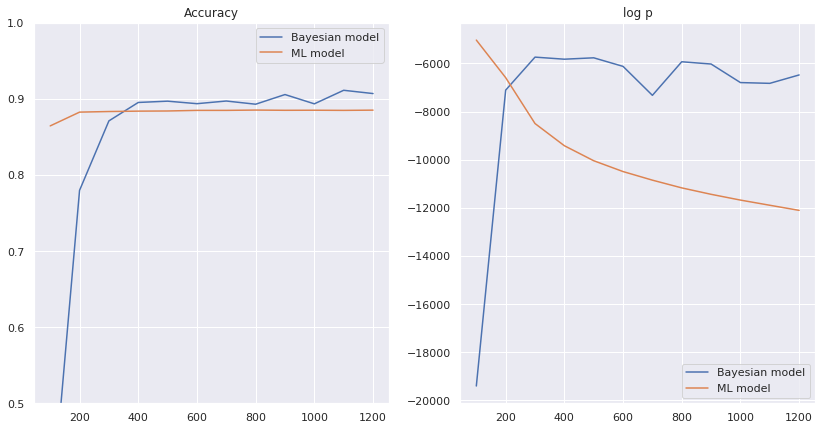

In [154]:
import pandas as pd
deterministic = False
bayesian_data = pd.read_csv(f"mnist-covariance{('-deterministic' if deterministic else '')}.txt", names=['step','accuracy', 'elbo'])
                            
deterministic = True
ml_data = pd.read_csv(f"mnist-covariance{('-deterministic' if deterministic else '')}.txt", names=['step','accuracy', 'elbo'])
                                 
print(len(bayesian_data), len(ml_data))
           
plt.figure(figsize=(14, 7))
plt.subplot(1,2,1)
plt.title("Accuracy")
plt.plot(bayesian_data['step'], bayesian_data['accuracy'], label='Bayesian model')
plt.plot(ml_data['step'], ml_data['accuracy'], label='ML model')
plt.legend()
plt.ylim([0.5, 1])
          
plt.subplot(1,2,2)        
plt.title("log p")
plt.plot(bayesian_data['step'], bayesian_data['elbo'], label='Bayesian model')
plt.plot(ml_data['step'], ml_data['elbo'], label='ML model')
plt.legend()
#plt.ylim([-5000, 0])
plt.show()

In [63]:
ml_data

,step,accuracy,elbo
0,2000,0.8187,-5819.761230
1,2000,0.8736,-4345.066406
2,2000,0.8979,-3637.886963
3,2000,0.9090,-3078.148926
4,2000,0.9199,-2785.308105
5,2000,0.9292,-2347.657959
6,2000,0.9386,-2080.679688
7,2000,0.9411,-1941.885010


### Visualization

First we sample $a,b \sim q(a,b)$ according to the learned variational parameters. Get $N$ samples $a_i$ and $b_i$. Then sample from predictive distribution
$$t_i = a_i f_{\theta}(x_i) + b_i + \sigma \epsilon_i$$
with $\epsilon_i$ iid samples from $\mathcal{N}(0,1)$.

In [62]:
### Get classifier output for the whole dataset and for many samples of the last layer's weights
n_samples = 50   
N = 200   # TODO the following stuff is computed only on N samples of training set!!
with torch.no_grad():
    # Compute deterministic NN output
    x = torch.cat([train_loader.dataset[i][0].unsqueeze(0) for i in range(N)], dim=0)
    t_values = torch.cat([train_loader.dataset[i][1].unsqueeze(0) for i in range(N)])
    h = features(x)
    cov_ab = flat_to_triangular(cov_ab_params)
    y_all = []
    for i in range(n_samples):
        # Sample last layer's weights from posterior q(a, b)
        ab_sample = stochastic(mu_ab, make_cholesky(logvar_ab, cov_ab))
        a, b = ab_sample[:-b_size], ab_sample[-b_size:]
        a = a.view(a_shape)
        b = b.unsqueeze(0)
        
        # Compute last layer output (the logits) with the weights just sampled
        y = h @ a + b    # shape: (N, n_classes)
        
        y_all.append(y.softmax(1).unsqueeze(0).cpu().numpy())

y_all = np.concatenate(y_all, axis=0)  # shape: (n_samples, N, n_classes)


### Get predictions (argmax) for all samples of weights (a,b)
pred_class = np.argmax(y_all, axis=-1)   # tensor of indices, shape (n_samples, N)
pred_class_onehot = onehot(pred_class)
pred_class_mean = pred_class_onehot.mean(0)   # shape (N, n_classes)
# pred_class_mean: for each input point a vector of size n_classes that sums to 1


### Get confusion matrix based on those samples
conf_matrix = np.zeros((n_classes, n_classes))
for i in range(N):
    conf_matrix[t_values[i]] += pred_class_mean[i]
conf_matrix /= conf_matrix.sum(1, keepdims=True)



### Show confusion matrix
plt.imshow(conf_matrix)
plt.colorbar()
plt.grid(False)
clean_curr_axes()
plt.title('Confusion matrix (rows sum to 1)')
plt.xlabel('Predicted top class')
plt.ylabel('True class')
plt.show()


AttributeError: 'int' object has no attribute 'unsqueeze'

In [ ]:
L = make_cholesky(logvar_ab, cov_ab).detach().cpu().numpy()
Cov = L @ L.T
inv_stds = np.diag(np.diag(Cov)**(-0.5))
Corr = inv_stds @ Cov @ inv_stds

plt.title("Cholesky Matrix")
plt.imshow(L)
plt.colorbar()
plt.show()

plt.title("Covariance Matrix")
plt.imshow(Cov)
plt.colorbar()
plt.show()

plt.title("Correlation Matrix")
plt.imshow(Corr)
plt.colorbar()
plt.show()

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.title("Means of last layer's parameters")
plt.hist(mu_ab.detach(), bins=25)
plt.subplot(1, 3, 2)
plt.title("Variances of last layer's parameters")
plt.hist(logvar_ab.exp().detach(), bins=25)
plt.subplot(1, 3, 3)
plt.title("Correlations of last layer's parameters")  # corr coefficients between pairs of DIFFERENT variables
correlations = Corr[~np.eye(Corr.shape[0], dtype=bool)]
plt.hist(correlations, bins=25)
plt.show()

### Uncertainty

* rotation [dropout as Baysian paper](https://arxiv.org/pdf/1506.02142.pdf)
* add noise